<a href="https://colab.research.google.com/github/Innovativeanku/Face-recognition-using-lstm-and-cnn/blob/main/DCT_on_Image_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!sudo apt-get update
!sudo apt-get install python3.7

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,085 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,233 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,254 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [28.1 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [962 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,059 kB]
Get:13 https://ppa

In [4]:
pip install opencv-python

In [13]:
from google.colab.patches import cv_imshow

scanning & dct starting...


<ipython-input-17-d97bb38207b2>:48: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp = np.asarray(temp, dtype=np.float)


scanning & dct over!
lexicographic ordering starting...
lexicographic ordering over!
euclidean operations starting...
euclidean operations over!
elimination starting...
elimination over!
painting starting...
painting over!
accuracy calculating...
Accuracy: 0.7478869134363159
accuracy calculated!


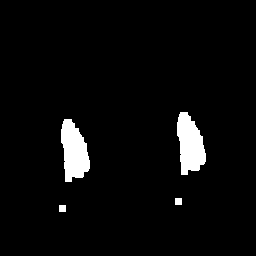

Prediction Mask None


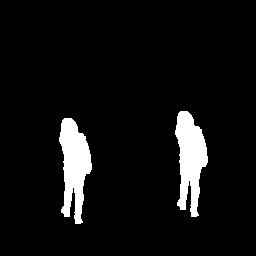

Real Mask None


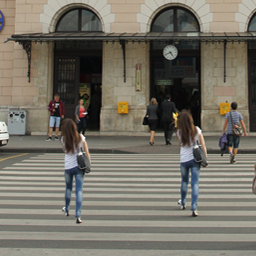

Original Image None


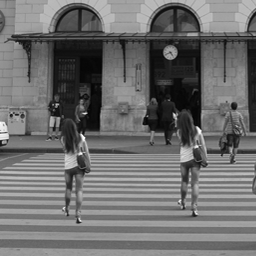

Gray Image None


In [17]:
import cv2
import numpy as np

quantization = 16
tsimilarity = 5 # euclid distance similarity threshhold
tdistance = 20 # euclid distance between pixels threshold
vector_limit = 20 # shift vector elimination limit
block_counter = 0
block_size = 8
image = cv2.imread('/content/drive/MyDrive/forged2.png')
mask = cv2.imread('/content/drive/MyDrive/forged2_mask.png')
mask_gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
temp = []
arr = np.array(gray)
mask = np.array(mask_gray)
prediction_mask = np.zeros((arr.shape[0], arr.shape[1]))
column = arr.shape[1] - block_size
row = arr.shape[0] - block_size
dcts = np.empty((((column+1)*(row+1)), quantization+2))


print("scanning & dct starting...")

for i in range(0, row):
    for j in range(0, column):

        blocks = arr[i:i+block_size, j:j+block_size]
        imf = np.float32(blocks) / 255.0  # float conversion/scale
        dst = cv2.dct(imf)  # the dct
        blocks = np.uint8(np.float32(dst) * 255.0 ) # convert back
        # zigzag scan
        solution = [[] for k in range(block_size + block_size - 1)]
        for k in range(block_size):
            for l in range(block_size):
                sum = k + l
                if (sum % 2 == 0):
                    # add at beginning
                    solution[sum].insert(0, blocks[k][l])
                else:
                    # add at end of the list
                    solution[sum].append(blocks[k][l])

        for item in range(0,(block_size*2-1)):
            temp += solution[item]

        temp = np.asarray(temp, dtype=np.float)
        temp = np.array(temp[:16])
        temp = np.floor(temp/quantization)
        temp = np.append(temp, [i, j])

        np.copyto(dcts[block_counter], temp)

        block_counter += 1
        temp = []

print("scanning & dct over!")



print("lexicographic ordering starting...")

dcts = dcts[~np.all(dcts == 0, axis=1)]
dcts = dcts[np.lexsort(np.rot90(dcts))]

print("lexicographic ordering over!")



print("euclidean operations starting...")

sim_array = []
for i in range(0, block_counter):
    if i <= block_counter-10:
        for j in range(i+1, i+10):
            pixelsim = np.linalg.norm(dcts[i][:16]-dcts[j][:16])
            pointdis = np.linalg.norm(dcts[i][-2:]-dcts[j][-2:])
            if pixelsim <= tsimilarity and pointdis >= tdistance:
                sim_array.append([dcts[i][16], dcts[i][17], dcts[j][16], dcts[j][17],dcts[i][16]-dcts[j][16], dcts[i][17]-dcts[j][17]])
    else:
        for j in range(i+1, block_counter):
            pixelsim = np.linalg.norm(dcts[i][:16]-dcts[j][:16])
            pointdis = np.linalg.norm(dcts[i][-2:]-dcts[j][-2:])
            if pixelsim <= tsimilarity and pointdis >= tdistance:
                sim_array.append([dcts[i][16], dcts[i][17], dcts[j][16], dcts[j][17],dcts[i][16]-dcts[j][16], dcts[i][17]-dcts[j][17]])

print("euclidean operations over!")



print("elimination starting...")

sim_array = np.array(sim_array)
delete_vec = []
vector_counter = 0
for i in range(0, sim_array.shape[0]):
    for j in range(1, sim_array.shape[0]):
        if sim_array[i][4] == sim_array[j][4] and sim_array[i][5] == sim_array[j][5]:
            vector_counter += 1
    if vector_counter < vector_limit:
        delete_vec.append(sim_array[i])
    vector_counter = 0

delete_vec = np.array(delete_vec)
delete_vec = delete_vec[~np.all(delete_vec == 0, axis=1)]
delete_vec = delete_vec[np.lexsort(np.rot90(delete_vec))]

for item in delete_vec:
    indexes = np.where(sim_array == item)
    unique, counts = np.unique(indexes[0], return_counts=True)
    for i in range(0, unique.shape[0]):
        if counts[i] == 6:
            sim_array = np.delete(sim_array,unique[i],axis=0)

print("elimination over!")



print("painting starting...")

for i in range(0, sim_array.shape[0]):
    index1 = int(sim_array[i][0])
    index2 = int(sim_array[i][1])
    index3 = int(sim_array[i][2])
    index4 = int(sim_array[i][3])
    for j in range(0,7):
        for k in range(0,7):
            prediction_mask[index1+j][index2+k] = 255
            prediction_mask[index3+j][index4+k] = 255

print("painting over!")



print("accuracy calculating...")

TP = 0
FP = 0
TN = 0
FN = 0

for i in range(0, prediction_mask.shape[0]):
    for j in range(0, prediction_mask.shape[1]):
        if prediction_mask[i][j] == mask[i][j]:
            if prediction_mask[i][j] == 255:
                TP += 1
            else:
                TN += 1
        else:
            if prediction_mask[i][j] == 255:
                FP += 1
            else:
                FN += 1

precision = TP/(TP+FP)
recall = TP/(TP+FN)
accuracy = 2*precision*recall/(precision+recall)

print('Accuracy:', accuracy)

print("accuracy calculated!")



print('Prediction Mask',cv2_imshow(prediction_mask))
print('Real Mask', cv2_imshow( mask))
print('Original Image',cv2_imshow(image))
print('Gray Image',cv2_imshow(gray))

cv2.waitKey(0)
cv2.destroyAllWindows()